In [2]:
from __future__ import print_function
import os
import sys
import math
import pickle
import pdb
import argparse
import random
from tqdm import tqdm
from shutil import copy
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from scipy.linalg import qr 
import igraph as ig
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from util import *
from modelsRIGHT import *
from igraph import *
import networkx as nx
from collections import Counter
import importlib
from sklearn.decomposition import PCA
from dotmap import DotMap
import pandas as pd
import json
from scipy.stats import wasserstein_distance
import csv
from pathlib import Path
import re
import visualize_util
from visualize_util import *

p = os.path.join("vertex_5_7dim_latent_KL1_DVAE_NOBATCHNORM_hs128_batchsize128","final_structures6_1")
vis_path = os.path.join(p, "evaluation")
csv_file_path = "summary.csv"
if( not os.path.exists(vis_path)):
    os.makedirs(vis_path)
argsFile = os.path.join(p,"cmd_input.txt")
with open(argsFile) as f:
    argsJSON = json.load(f)
args = DotMap(argsJSON)



In [3]:
# df = pd.read_csv("vertex_4_2dim_latent_batchnorm2\\final_structures6\\train_loss.txt", sep= " ")
# df2 = pd.read_csv("vertex_4_4dim_latent\\final_structures6\\train_loss.txt", sep= " ")
# df3 = pd.read_csv("train_lossBIG.txt", sep= " ")
# df4 = pd.read_csv("vertex_4_2dimLatent_new\\final_structures6\\train_loss.txt", sep= " ")
df5 = pd.read_csv(os.path.join(p,"train_loss.txt"), sep= " ")

ix=df5.iloc[:,[0,2]].sum(1).idxmin()
# print(ix)
# print(df5.iloc[[300]])


<Figure size 600x400 with 0 Axes>

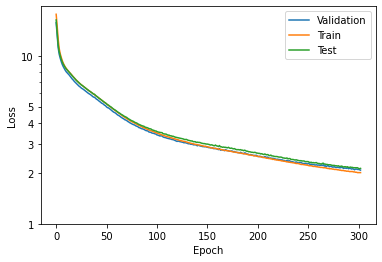

In [4]:
plt.figure(dpi = 100)
fig1, ax1 = plt.subplots()
ax1.plot(df5.iloc[:,3], label='Validation')
ax1.plot(df5.iloc[:,0], label='Train')
ax1.plot(df5.iloc[:,4], label='Test')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_yscale('log')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')


ax1.legend()
ax1.set_yticks([10,5,4,3,2,1])
ax1.set_yticklabels([10,5,4,3,2,1])
ax1.get_yaxis().get_major_formatter().labelOnlyBase = False
# plt.plot(df3.iloc[:2949,4], label='Total')

In [5]:

print(args.seed)
print(args)
print(type(args.seed))
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
np.random.seed(args.seed)
random.seed(args.seed)
print(device)


1
DotMap(cuda=True, all_gpus=False, bidirectional=False, continue_from=None, data_name='final_structures6', data_type='BN', infer_batch_size=128, keep_old=False, load_latest_model=False, no_cuda=False, no_test=False, only_test=False, predictor=False, reprocess=False, sample_number=20, save_appendix='', seed=1, small_train=False, epochs=3000, save_interval=1, model='DVAE_NOBATCHNORM', lr=0.0001, save_start=0, early_stop_patience=50, nvt=7, max_n=7, batch_size=128, hs=128, nz=7, beta=1, file_dir='../input/dvae-vertex5/graph_data', res_dir='/kaggle/working/vertex_5_7dim_latent_KL1_DVAE_NOBATCHNORM_hs128_batchsize128/final_structures6_1', scheduler_dir='/kaggle/working/vertex_5_7dim_latent_KL1_DVAE_NOBATCHNORM_hs128_batchsize128/final_structures6_1/scheduler', optimizer_dir='/kaggle/working/vertex_5_7dim_latent_KL1_DVAE_NOBATCHNORM_hs128_batchsize128/final_structures6_1/optimizer', model_dir='/kaggle/working/vertex_5_7dim_latent_KL1_DVAE_NOBATCHNORM_hs128_batchsize128/final_structures6_1/m

In [6]:
graph_args = DotMap()
graph_args.max_n = args.nvt
graph_args.num_vertex_type = args.max_n
graph_args.START_TYPE = 0
graph_args.END_TYPE = 1
model = eval(args.model)(
        graph_args.max_n, 
        graph_args.num_vertex_type, 
        graph_args.START_TYPE, 
        graph_args.END_TYPE, 
        hs=args.hs, 
        nz=args.nz, 
        bidirectional=args.bidirectional        )
model.device = device
model = model.to(device)
print(model.get_device())
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)
print(graph_args)

cuda:0
DotMap(max_n=7, num_vertex_type=7, START_TYPE=0, END_TYPE=1)


In [7]:
all_data = []
all_data_cleaned = []
train_data = []
test_data = []
graph_path = os.path.join("..", "graph_data", "vertex_5")
for ix,filename in enumerate(tqdm(os.listdir(graph_path))):
    path = os.path.join(graph_path, filename)
    with open(path, 'rb') as pickle_file:
        # Load file
        graph = pickle.load(pickle_file)
        edge_list = graph.get_edgelist()
        # Create new graph
        graph2 = ig.Graph(directed=True)
        graph2.add_vertices(args.max_n)
        # Copy vertices to new graph
        for vs_i in range(len(graph.vs)):
            graph2.vs[vs_i+1]['type'] =  graph.vs[vs_i]['_nx_name']+2
        # Copy edges to new graph
        for edge_pair in edge_list:
            p1 = edge_pair[0]
            p2 = edge_pair[1]
            graph2.add_edge(p1+1,p2+1)
        # Set vertex attributes
        graph2.vs[0]['type'] = graph_args.START_TYPE
        graph2.vs[args.max_n-1]['type'] = graph_args.END_TYPE
        # graph2.add_edge(0,1)
        # graph2.add_edge(4,5)

        for vs_i,vs in enumerate(graph2.vs[1:-1]):
            if(len(vs.in_edges()) == 0):
                graph2.add_edge(0, vs_i+1)
            if(len(vs.out_edges()) == 0):
                graph2.add_edge(vs_i+1, len(graph2.vs)-1)
        all_data.append(graph2)
        all_data_cleaned.append(graph2)

print(all_data[0].vs["type"])
# print(all_data[1].vs["type"])
print(len(all_data))



100%|██████████| 29281/29281 [02:34<00:00, 189.35it/s]

[0, 2, 3, 4, 5, 6, 1]
29281


In [8]:

model_dir = os.path.join(p, "model")
print(model_dir)
files = [os.path.join(model_dir, file) for file in os.listdir(model_dir)]
latest_checkpoint = max(files, key= os.path.getctime)
print(latest_checkpoint)
latest_checkpoint_filename = Path(latest_checkpoint).name
print(latest_checkpoint_filename)
last_epoch = re.findall(r'\d+', latest_checkpoint_filename)
print(last_epoch[0])

# q = 563
# latest_checkpoint = os.path.join(model_dir,"model_checkpoint"+str(q)+".pth")
# print(latest_checkpoint)
load_module_state(model,latest_checkpoint)



vertex_5_7dim_latent_KL1_DVAE_NOBATCHNORM_hs128_batchsize128\final_structures6_1\model
vertex_5_7dim_latent_KL1_DVAE_NOBATCHNORM_hs128_batchsize128\final_structures6_1\model\model_checkpoint90.pth
model_checkpoint90.pth
90


In [9]:
# ENCODE ALL DATA

importlib.reload(visualize_util)

latents = []
extended = []
min_mu = 2
max_mu = -1
min_g = None
max_g = None
percect_recon = 0
i = 0
for data in tqdm(all_data):
    mu, logvar = model.encode(data)
    z = model.reparameterize(mu,logvar)
    # g_recon = model.decode(z)

    # h1 = visualize_util.DAG_hash(data)
    # for g_r in g_recon:
    #     h2 = visualize_util.DAG_hash(g_r)
    #     if h1 == h2:
    #         percect_recon+=1
    #         break
    mu = mu.cpu().detach().numpy()

    latents.append(mu)
    null_edges = data.neighbors(0, 'out')
    # print(data.vcount())
    end_edges = data.neighbors(args.max_n-1, 'in')
    max_degree = np.max(data.vs.degree())
    in_degree = np.max(data.vs.indegree())
    out_degree = np.max(data.vs.outdegree())
    zero_pred =  len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "in") == [0]])    
    zero_succ = len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "out") == [args.max_n-1]])
    
    minus_edges = len(null_edges) + len(end_edges)
    mu  = np.append(mu, data.ecount()- minus_edges)
    mu  = np.append(mu, max_degree)
    mu  = np.append(mu, in_degree)
    mu  = np.append(mu, out_degree)
    mu  = np.append(mu, zero_pred)
    mu  = np.append(mu, zero_succ)
    if i <= 10:
        break
    i+=1




    
    extended.append(mu)

latents = np.array(latents)
extended = np.array(extended)
print(latents.shape)
# print(latents)

  0%|          | 0/29281 [00:02<?, ?it/s]

(1, 1, 7)


In [10]:
print("Z_mean: " + str(latents.mean(0)))
print("Z_std: " + str(latents.std(0)))
print("Z norm: " + str(np.linalg.norm(latents)))

Z_mean: [[-0.57493615  2.8788939  -0.41564322  0.559375    1.7095213   2.514858
   0.9306456 ]]
Z_std: [[0. 0. 0. 0. 0. 0. 0.]]
Z norm: 4.3837557


In [12]:
# TODO
# Hash all_data, create {hash, index} map, map hashes, create array from indexes, np hist
import importlib
importlib.reload(visualize_util)
all_data_hashes = {}
for ix,a in enumerate(all_data_cleaned):
    g_a_hash = visualize_util.DAG_hash(a)
    all_data_hashes[g_a_hash] = ix

print(len(all_data_hashes))

29281


In [ ]:
a = latents.reshape((len(all_data),args.nz))
pca = PCA(n_components=2)
components = pca.fit_transform(a)
print(type(components))

fig, ax = plt.subplots(facecolor=(1, 1, 1))
scatter = ax.scatter(components[:,0], components[:,1], c=extended[:,args.nz])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left",bbox_to_anchor=(1.04, 1))
ax.add_artist(legend1)
fig_name = os.path.join(vis_path, "all_data_encoded")
fig.savefig(fig_name,bbox_inches='tight')
plt.show()



ValueError: cannot reshape array of size 7 into shape (29281,7)

In [13]:


def prior_validity():
    Z_train = latents
    Zs_valid = []
    Zs_invalid = []
    Zs_plus_decode = []
    Wrapped_G = []
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    # print(z_mean)
    # print(z_std)
    z_mean, z_std = torch.FloatTensor(z_mean).to(device), torch.FloatTensor(z_std).to(device)
    n_latent_points = 1000
    decode_times = 10
    n_valid = 0
    print('Prior validity experiment begins...')
    G = []
    G_valid = []
    G_train = [g for g in train_data]
    pbar = tqdm(range(n_latent_points))
    cnt = 0
    G_valid = []
    G_invalid = []
    n_valid = 0
    for i in pbar:
        cnt += 1
        if cnt == args.infer_batch_size or i == n_latent_points - 1:
            z = torch.randn(cnt, model.nz).to(model.get_device())
        # print(z)
            z = z * z_std + z_mean  # move to train's latent range
        # print(z)
            
            # print(z.cpu().detach().numpy())

            for j in range(decode_times):
                g_batch = model.decode(z)
                for ix,g in enumerate(g_batch):
                    if is_valid_BN(g, graph_args.START_TYPE, graph_args.END_TYPE,args.nvt):
                        n_valid +=1
                        G_valid.append(g)
                        Wrapped_G.append(GraphWrapper(g))
                        Zs_valid.append(z.cpu().detach().numpy()[ix])
                    else:
                        G_invalid.append(g)
                        Zs_invalid.append(z.cpu().detach().numpy()[ix])


            cnt = 0
    return G_valid, G_invalid, Zs_valid, Zs_invalid, Wrapped_G


valid, invalid, Zs_valid, Zs_invalid, Wrapped_G = prior_validity()
print(len(valid))
print(len(invalid))


Prior validity experiment begins...


100%|██████████| 1000/1000 [01:25<00:00, 11.71it/s]

9999
1


In [17]:
import collections
hash_indexes =[]
hashes = []
for w_g in valid:
    h = visualize_util.DAG_hash(w_g)
    ix = all_data_hashes[h]
    # print(h)
    hash_indexes.append(ix)
    hashes.append(h)

counter = collections.Counter(hashes)
c_values = list(counter.values())
print(c_values)
# hashes.append(visualize_util.DAG_hash(valid[0]))

[8134, 327, 149, 102, 138, 477, 108, 116, 9, 7, 1, 98, 90, 26, 9, 17, 3, 1, 10, 6, 8, 3, 11, 14, 2, 7, 1, 21, 1, 1, 4, 9, 6, 5, 18, 1, 11, 1, 5, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 2, 1, 1, 2, 2, 1, 1, 4, 4, 1, 1, 3, 1, 1, 1, 1, 1]


In [ ]:
print(len(all_data))
print(len(valid))
valid_cleaned = valid.copy()
for g in all_data_cleaned:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

for g in valid_cleaned:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

29281
30329


In [39]:
# NEM FOG LEFUTNI
# from wrapper import GraphWrapper
import wrapper
importlib.reload(wrapper)
# decode_ix = []
# for v_ix,v in enumerate(tqdm(valid_cleaned)) :
#     for d_ix,d in enumerate(all_data_cleaned):
#         if is_same_DAG2(v,d):
#             decode_ix.append(d_ix)
#             break
        
# print(len(decode_ix))
# print()

w_g = wrapper.GraphWrapper(all_data[1]) 
adj = w_g.graph.get_adjacency()
print(adj)
print(w_g.graph.vs["type"])
print("---------")
print(w_g.__hash__())
print(type(adj))



[[0, 1, 1, 1, 1]
 [0, 0, 1, 1, 1]
 [0, 0, 0, 1, 1]
 [0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0]]
[2, 3, 4, 6, 5]
---------
2345604000234020
<class 'igraph.datatypes.Matrix'>


In [40]:
print(adj)
n = w_g.graph
# print(n)
arr = [a for a in adj]
# print(arr)
n = np.array(arr)




n_c = []
c_c = {}
adj = w_g.graph.get_adjacency()
for i_l,l in enumerate(adj[:]):
    if len(c_c) == 0:
            c_c[w_g.graph.vs["type"][i_l]] = i_l
    if i_l != adj.shape[0]-1 and l[i_l+1] == 0:
        c_c[w_g.graph.vs["type"][i_l+1]] = i_l+1
    else:
        n_c.append(c_c)
        c_c = {}

e_c = []
for n in n_c:
    x = dict(sorted(n.items()))
    e_c.append(x)

res = []

print(e_c)


res = [adj[s_e] for e in e_c for s_e in e.values()]
r_n = np.array(res)
print(r_n)
print("------")
f_r = [r_n[:,s_e] for e in e_c for s_e in e.values()]
flat_list = [item for sublist in f_r for item in sublist]
print(flat_list)
res_labels = [s_e for e in e_c for s_e in e.keys()]
print(w_g.__hash__())


[[0, 1, 1, 1, 1]
 [0, 0, 1, 1, 1]
 [0, 0, 0, 1, 1]
 [0, 0, 0, 0, 1]
 [0, 0, 0, 0, 0]]
[{2: 0}, {3: 1}, {4: 2}, {6: 3}, {5: 4}]
[[0 1 1 1 1]
 [0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]
------
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
2345604000234020


In [41]:
counter = collections.Counter(hashes)
c_values = list(counter.values())

# print(c_values)

In [ ]:
print(np.max(c_values))
print(hashes[0])

1


NameError: name 'Wrapped_G' is not defined

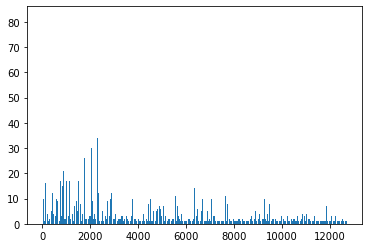

In [ ]:
# import collections
# hashes = []
# for w_g in Wrapped_G:
#     to_append = w_g.__hash__()
#     hashes.append(to_append)

# counter = collections.Counter(hashes)
# c_values = list(counter.values())
# # print(c_values)
# print(len(c_values))
# print(np.max(c_values))
# plt.bar([i for i in range(len(c_values))], c_values)
# plt.show()

NameError: name 'hashes' is not defined

44475


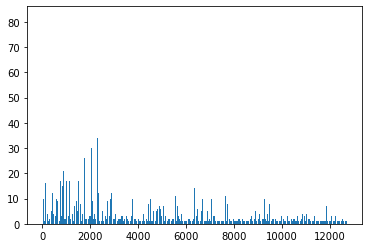

[4, 2, 3, 8, 11, 24, 4, 7, 11, 10, 2, 28, 11, 3, 4, 4, 8, 1, 4, 22, 15, 3, 2, 3, 7, 16, 9, 23, 4, 3, 5, 10, 9, 5, 1, 2, 12, 3, 2, 3, 7, 2, 9, 16, 6, 54, 6, 1, 12, 1, 27, 3, 4, 1, 9, 10, 6, 5, 4, 3, 13, 4, 18, 8, 5, 5, 9, 1, 7, 5, 4, 2, 13, 7, 12, 21, 3, 1, 1, 10, 1, 28, 3, 2, 15, 9, 1, 46, 2, 11, 24, 3, 3, 2, 1, 2, 10, 1, 15, 12, 45, 5, 15, 13, 10, 5, 7, 3, 2, 1, 82, 34, 13, 15, 51, 1, 5, 3, 2, 2, 13, 2, 4, 3, 10, 1, 46, 1, 2, 3, 13, 3, 1, 13, 47, 15, 2, 4, 13, 16, 3, 7, 8, 19, 1, 8, 4, 10, 3, 4, 13, 9, 34, 21, 3, 16, 11, 1, 7, 8, 6, 1, 4, 45, 9, 5, 1, 2, 25, 6, 44, 11, 27, 3, 8, 5, 17, 8, 10, 1, 17, 6, 1, 4, 8, 2, 8, 7, 3, 10, 3, 5, 4, 2, 5, 2, 24, 2, 2, 10, 9, 6, 3, 3, 44, 4, 9, 8, 2, 4, 6, 6, 23, 4, 36, 7, 22, 2, 13, 5, 3, 3, 4, 1, 30, 1, 5, 7, 2, 7, 2, 10, 4, 28, 12, 3, 1, 4, 7, 1, 2, 2, 8, 2, 2, 14, 25, 5, 12, 2, 37, 1, 5, 2, 11, 3, 16, 17, 9, 1, 10, 5, 13, 5, 1, 4, 1, 7, 7, 1, 2, 4, 2, 3, 20, 19, 1, 12, 5, 7, 7, 5, 3, 15, 26, 3, 9, 14, 2, 8, 9, 9, 6, 2, 18, 6, 2, 1, 8, 7, 2, 1, 4

In [43]:
mapped_hashes = [ all_data_hashes[h] if h in all_data_hashes else len(all_data_cleaned) for h in hashes]
print(len(mapped_hashes))
counter = collections.Counter(mapped_hashes)
c_values = list(counter.values())
plt.bar([i for i in range(len(c_values))], c_values)
plt.show()
print(c_values)

In [44]:
# print(all_data_hashes)

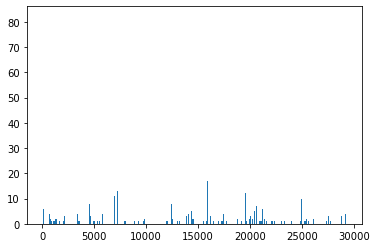

In [45]:
hist1 = np.histogram(mapped_hashes,bins = len(all_data_cleaned))
plt.bar([i for i in range(len(hist1[0]))], hist1[0])
fig_name = os.path.join(vis_path, "frequencies")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))
plt.show()


In [46]:
print(hist1[0])
print(len(hist1[0]))


[29 14 18 ...  0  0  1]
29281


In [47]:
print(hist1)


(array([29, 14, 18, ...,  0,  0,  1], dtype=int64), array([0.00000000e+00, 9.99863393e-01, 1.99972679e+00, ...,
       2.92750003e+04, 2.92760001e+04, 2.92770000e+04]))


In [48]:
uni = np.random.randint(0,542,len(all_data))
uni2 = np.random.randint(0,542,len(all_data))
m_mean =np.mean(hist1[0][:-2])
m_median =np.median(hist1[0][:-2])
m_std = np.std(hist1[0][:-2])
m_max = np.max(hist1[0][:-2])
m_max_ix = np.argmax(hist1[0])
m_wasser = wasserstein_distance(uni,hist1[0][:-2])
print("Mean: " + str(m_mean))
print("Median: " + str(m_median))
print("Std: " + str(m_std))
print("Max: " + str(m_max))
print("Max index: " + str(m_max_ix))
print("Distance from uniform distribution: " + str(m_wasser))
print("Uni to Uni: " + str(wasserstein_distance(uni,uni2)))
dir_name = Path(p).parent.name

# csv_file_path = "s2.csv"
with open(csv_file_path, 'a+', newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter = ';' )
    writer.writerow([dir_name,args.model, last_epoch[0], args.nz, args.hs,  args.beta,m_mean, m_median, m_std,m_max, m_wasser, len(valid)])



Mean: 1.5189726425082823
Median: 0.0
Std: 3.603344467583437
Max: 82
Max index: 25021
Distance from uniform distribution: 269.1872873895944
Uni to Uni: 1.82182985553772


29281


<BarContainer object of 543 artists>

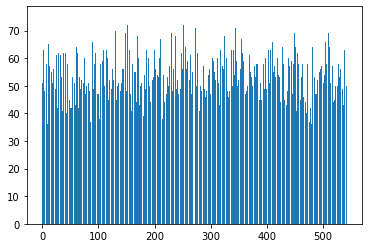

In [49]:
# print(uni)
print(len(uni))
hist2 = np.histogram(uni, bins=543)
plt.bar([i for i in range(len(hist2[0]))], hist2[0])

In [50]:
from scipy import stats
print(stats.mode(decode_ix))

NameError: name 'decode_ix' is not defined

In [ ]:
test_g = all_data[0]
print(test_g)
print(test_g.get_adjacency())
flat_list = [item for sublist in test_g.get_adjacency()[1:] for item in sublist[:-1]]
print(flat_list)
print(len(flat_list))
print(test_g.vs["type"])
hash_list = flat_list + test_g.vs["type"]
print(hash_list)
hash_list_str = ''.join(map(str,hash_list))
print(int(hash_list_str))

In [ ]:
Zs_valid = np.array(Zs_valid)
print(Zs_valid.shape)

pca = PCA(n_components=2)
sampled_components = pca.fit_transform(Zs_valid)
# plt.scatter(components[:,0], components[:,1], c=extended[:,6])

plt.scatter(sampled_components[:,0], sampled_components[:,1], c=decode_ix)
fig_name = os.path.join(vis_path, "sampled")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))

# plt.scatter(Zs_valid[:,0], Zs_valid[:,1], c=decode_ix)

In [ ]:
most_common = counter.most_common(1)[0][0]
print(most_common)

to_print = [ix for ix in range(len(decode_ix)) if decode_ix[ix] == most_common]
print(len(to_print))
Zs_valid_filtered = [Zs_valid[x] for x in range(len(Zs_valid)) if x in to_print]
print(len(Zs_valid_filtered))
Zs_valid_filtered = np.array(Zs_valid_filtered)
plt.scatter(Zs_valid_filtered[:,0], Zs_valid_filtered[:,1])

In [ ]:
Zs_invalid = np.array(Zs_invalid)
print(Zs_invalid.shape)
plt.scatter(Zs_invalid[:,0], Zs_invalid[:,1])